In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2
from sklearn.linear_model import LogisticRegressionCV

%matplotlib inline

# 1. Exploratory data analysis

### 1.1 Some statistics of the data

In [2]:
df = pd.read_csv('indian_food.csv', na_values=-1)
df.head()

,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,state,region
0,Balu shahi,"Maida flour, yogurt, oil, sugar",vegetarian,45.0,25.0,sweet,dessert,West Bengal,East
1,Boondi,"Gram flour, ghee, sugar",vegetarian,80.0,30.0,sweet,dessert,Rajasthan,West
2,Gajar ka halwa,"Carrots, milk, sugar, ghee, cashews, raisins",vegetarian,15.0,60.0,sweet,dessert,Punjab,North
3,Ghevar,"Flour, ghee, kewra, milk, clarified butter, su...",vegetarian,15.0,30.0,sweet,dessert,Rajasthan,West
4,Gulab jamun,"Milk powder, plain flour, baking powder, ghee,...",vegetarian,15.0,40.0,sweet,dessert,West Bengal,East


In [3]:
df.shape

(255, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            255 non-null    object 
 1   ingredients     255 non-null    object 
 2   diet            255 non-null    object 
 3   prep_time       225 non-null    float64
 4   cook_time       227 non-null    float64
 5   flavor_profile  226 non-null    object 
 6   course          255 non-null    object 
 7   state           231 non-null    object 
 8   region          241 non-null    object 
dtypes: float64(2), object(7)
memory usage: 18.1+ KB


In [5]:
df.describe()

,prep_time,cook_time
count,225.000000,227.000000
mean,35.386667,38.911894
std,76.241081,49.421711
min,5.000000,2.000000
25%,10.000000,20.000000
50%,10.000000,30.000000
75%,20.000000,45.000000
max,500.000000,720.000000


The continuous features have right-skewed distribution, which we will examine further with some graphs in the next section

### 1.2 Visualizations

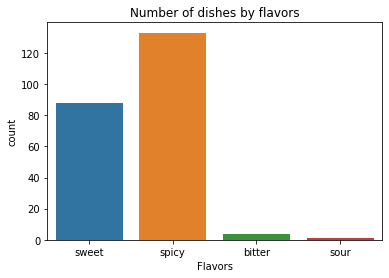

In [6]:
ax = sns.countplot(x = 'flavor_profile', data = df)
ax.set_title("Number of dishes by flavors")
ax.set_xlabel("Flavors")
plt.show()

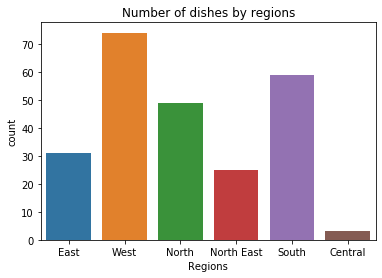

In [7]:
ax = sns.countplot(x = 'region', data = df)
ax.set_title("Number of dishes by regions")
ax.set_xlabel("Regions")
plt.show()

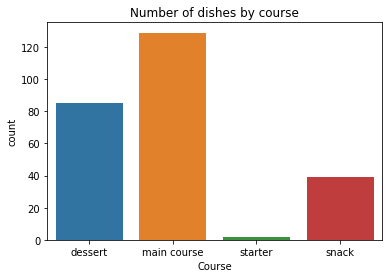

In [8]:
ax = sns.countplot(x = 'course', data = df)
ax.set_title("Number of dishes by course")
ax.set_xlabel("Course")
plt.show()

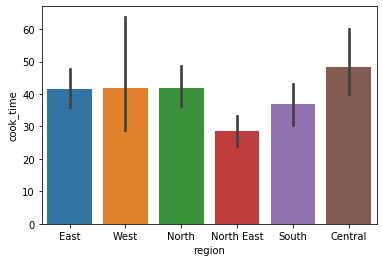

In [9]:
sns.barplot(data=df, x="region", y="cook_time")
plt.show()

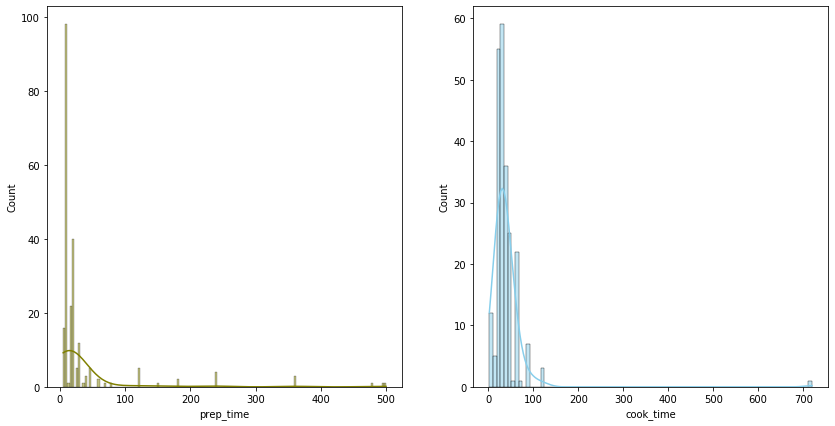

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
sns.histplot(data = df, x = 'prep_time', kde = True, color='olive', ax =ax[0])
sns.histplot(data = df, x = 'cook_time', kde = True, color='skyblue', ax=ax[1])
plt.show()

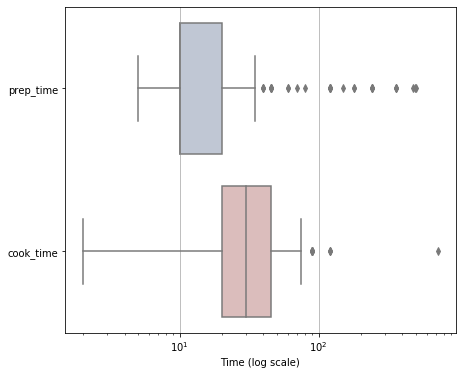

In [11]:
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")
sns.boxplot(data = df.loc[:,['prep_time', 'cook_time']], orient='h', palette='vlag')
ax.set_xlabel("Time (log scale)")
ax.xaxis.grid(True)
plt.show()

In [12]:
def draw_boxplots(x_val, xlab):
    fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
    ax[0].set_yscale("log")
    sns.boxplot(data = df, x =x_val, y="prep_time", palette='vlag', ax=ax[0])
    sns.boxplot(data = df, x =x_val, y="cook_time", palette='vlag', ax=ax[1])
    ax[0].set_ylabel("Prep time (log scale)")
    ax[0].set_xlabel(xlab)
    ax[0].set_title("Preparation time by " + xlab)
    ax[1].set_ylabel("Cook time (log scale)")
    ax[1].set_xlabel(xlab)
    ax[1].set_title("Cooking time by "+ xlab)
    plt.show()

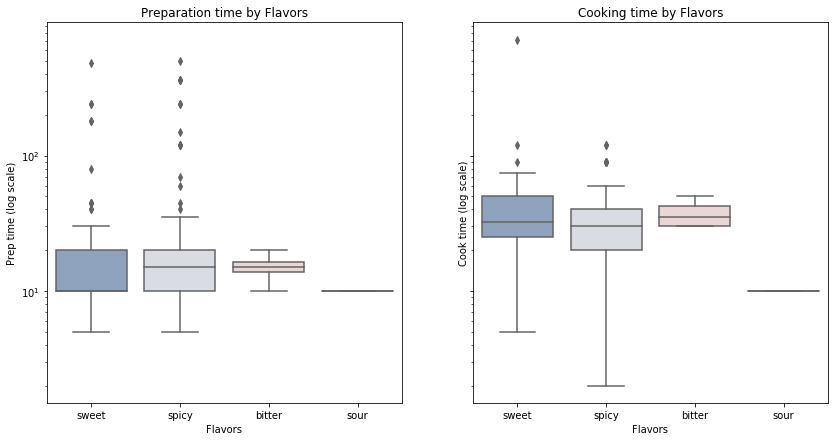

In [13]:
draw_boxplots("flavor_profile", "Flavors")

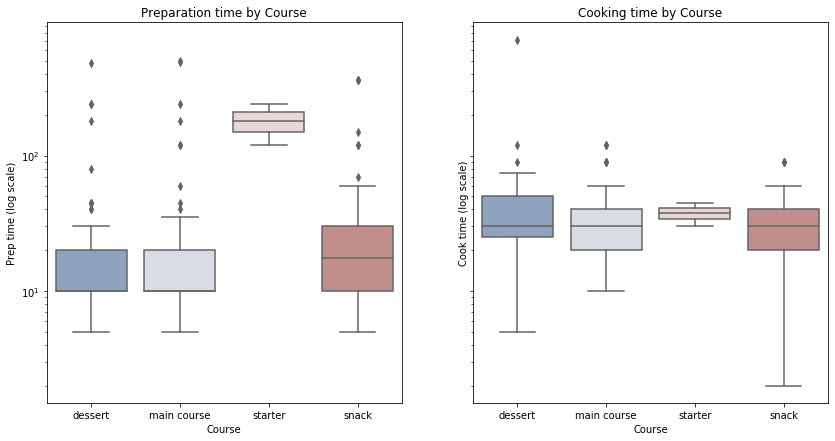

In [14]:
draw_boxplots("course", "Course")

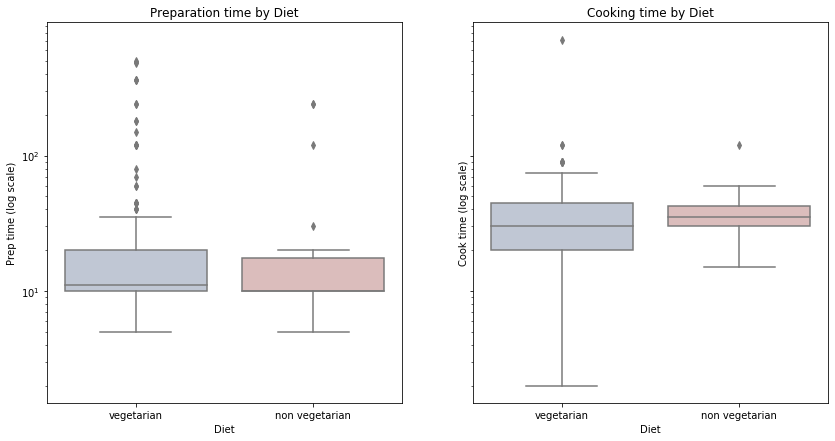

In [15]:
draw_boxplots("diet", "Diet")

In [16]:
df['diet'].value_counts()

vegetarian        226
non vegetarian     29
Name: diet, dtype: int64

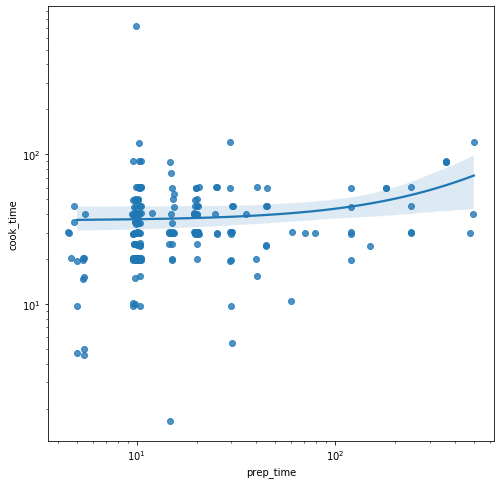

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.regplot(data=df, x='prep_time', y='cook_time', scatter=True, y_jitter=0.5, x_jitter=0.5)
plt.yscale('log')
plt.xscale('log')
plt.show()

### 1.3 Missing data

In [18]:
df.isnull().mean().round(4)*100

name               0.00
ingredients        0.00
diet               0.00
prep_time         11.76
cook_time         10.98
flavor_profile    11.37
course             0.00
state              9.41
region             5.49
dtype: float64

In [19]:
# since the data is skewed, we use mode to impute the missing data in prep_time
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_wo_state_region = df.copy()
df_wo_state_region.drop(['state', 'region'], axis=1, inplace=True)
df_wo_state_region.dropna(subset=['cook_time'], inplace=True)
df_wo_state_region['prep_time'] = imp.fit_transform(df_wo_state_region['prep_time'].values.reshape(-1, 1))
print(df_wo_state_region.isnull().mean().round(4)*100)
print(df_wo_state_region.shape)

name               0.00
ingredients        0.00
diet               0.00
prep_time          0.00
cook_time          0.00
flavor_profile    10.57
course             0.00
dtype: float64
(227, 7)


Around 10% of the data has missing flavor profile. Since our dataset is small, we will proceed to impute them. We will preprocess and encode the categorical variables before using KNN to fill in the missing flavor_profile values.

In [20]:
df_train = df_wo_state_region.copy()

In [21]:
# no duplicates
df_train.duplicated().any()

False

### 1.4 One hot encode categorical data

In [22]:
# preprocess ingredients columns
df_train['is_vegetarian'] = df_train['diet'].map({'vegetarian': 1, 'non vegetarian' : 0}).astype('object')
df_train.head()

,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,is_vegetarian
0,Balu shahi,"Maida flour, yogurt, oil, sugar",vegetarian,45.0,25.0,sweet,dessert,1
1,Boondi,"Gram flour, ghee, sugar",vegetarian,80.0,30.0,sweet,dessert,1
2,Gajar ka halwa,"Carrots, milk, sugar, ghee, cashews, raisins",vegetarian,15.0,60.0,sweet,dessert,1
3,Ghevar,"Flour, ghee, kewra, milk, clarified butter, su...",vegetarian,15.0,30.0,sweet,dessert,1
4,Gulab jamun,"Milk powder, plain flour, baking powder, ghee,...",vegetarian,15.0,40.0,sweet,dessert,1


In [23]:
df_train = df_train.reset_index(drop=True)

In [24]:
# discretize cook_time
bins = [0, 30, 60, 720]
group_names = ['quick', 'medium', 'slow']
df_train['cook_time'] = pd.cut(df_train['cook_time'], bins, labels=group_names)

In [25]:
df_train['cook_time'].value_counts()

quick     131
medium     84
slow       12
Name: cook_time, dtype: int64

In [26]:
# feature encoding for ingredients
# top ingredients by if-idf
from sklearn.feature_extraction.text import TfidfVectorizer

# by flavors
quick_dish = df_train[df_train['cook_time'] == "quick"]['ingredients']
medium_dish = df_train[df_train['cook_time'] == "medium"]['ingredients']
slow_dish = df_train[df_train['cook_time'] == "slow"]['ingredients']

# turn into one document
def one_doc(dishList):
    string = ''
    for dish in dishList:
        string = string + " " + dish
    return string

quick = one_doc(quick_dish)
medium = one_doc(medium_dish)
slow  = one_doc(slow_dish)

In [27]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform([quick, medium, slow])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
pd.DataFrame(denselist, columns=feature_names)

,acid,all,almond,almonds,aloo,alum,amaranth,amchur,and,anise,...,whipping,white,whole,wild,wine,yam,yellow,yoghurt,yogurt,yolks
0,0.01389,0.021127,0.000000,0.05556,0.02778,0.01389,0.01389,0.000000,0.000000,0.010564,...,0.000000,0.031691,0.082036,0.01389,0.000000,0.000000,0.000000,0.010564,0.095073,0.000000
1,0.00000,0.060786,0.000000,0.00000,0.00000,0.00000,0.00000,0.039963,0.019981,0.000000,...,0.019981,0.030393,0.059007,0.00000,0.019981,0.019981,0.019981,0.000000,0.030393,0.019981
2,0.00000,0.000000,0.097217,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.073936,...,0.000000,0.000000,0.057418,0.00000,0.000000,0.000000,0.000000,0.073936,0.000000,0.000000


In [28]:
all_important_ingre = []
for index, item in enumerate(denselist):
    scores = {feature: tfidf for feature, tfidf in zip(feature_names, item)}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for word, score in sorted_words[:10]:
        all_important_ingre.append(word)

print(set(all_important_ingre))
top_ingre = list(set(all_important_ingre))

{'idli', 'gram', 'urad', 'garam', 'rock', 'sugar', 'cardamom', 'coconut', 'curry', 'poha', 'green', 'leaves', 'milk', 'dal', 'chana', 'powder', 'thick', 'flour', 'rice', 'masala', 'ghee'}


In [29]:
zeros = np.zeros((len(df_train), len(top_ingre)))
dummies = pd.DataFrame(zeros, columns = top_ingre)

In [30]:
ingredients = df_train['ingredients']
sep_ingre = ingredients.apply(str.split, sep= ", ")
for i, dish in enumerate(sep_ingre):
    dish = list(map(str.lower, dish))
    indices = dummies.columns.get_indexer(dish)
    dummies.iloc[i, indices] = 1
dummies

,idli,gram,urad,garam,rock,sugar,cardamom,coconut,curry,poha,...,leaves,milk,dal,chana,powder,thick,flour,rice,masala,ghee
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [31]:
# one hot encoding the flavors
one_hot_encode_data = pd.get_dummies(df_train, columns=['flavor_profile', 'course'])

In [32]:
one_hot_encode_data = one_hot_encode_data.join(dummies.add_prefix('ingre_'))
one_hot_encode_data.drop(['ingredients', 'diet', 'name'], axis=1, inplace=True)

In [33]:
one_hot_encode_data

,prep_time,cook_time,is_vegetarian,flavor_profile_bitter,flavor_profile_sour,flavor_profile_spicy,flavor_profile_sweet,course_dessert,course_main course,course_snack,...,ingre_leaves,ingre_milk,ingre_dal,ingre_chana,ingre_powder,ingre_thick,ingre_flour,ingre_rice,ingre_masala,ingre_ghee
0,45.0,quick,1,0,0,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,80.0,quick,1,0,0,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,15.0,medium,1,0,0,0,1,1,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,15.0,quick,1,0,0,0,1,1,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,15.0,medium,1,0,0,0,1,1,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,15.0,medium,0,0,0,1,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
223,10.0,quick,1,0,0,1,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
224,5.0,quick,1,0,0,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
225,20.0,medium,1,0,0,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [34]:
one_hot_encode_data['cook_time'] = one_hot_encode_data['cook_time'].map({'quick': 1, 'medium' : 2, 'slow':3})

In [35]:
# use KNN to impute the values for 
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
one_hot_encode_data_full = imputer.fit_transform(one_hot_encode_data)

### 1.5 Train test split

In [36]:
train_info = pd.DataFrame(one_hot_encode_data_full, columns=one_hot_encode_data.columns)
train_info.head()

,prep_time,cook_time,is_vegetarian,flavor_profile_bitter,flavor_profile_sour,flavor_profile_spicy,flavor_profile_sweet,course_dessert,course_main course,course_snack,...,ingre_leaves,ingre_milk,ingre_dal,ingre_chana,ingre_powder,ingre_thick,ingre_flour,ingre_rice,ingre_masala,ingre_ghee
0,45.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,80.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,15.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,15.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,15.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [37]:
# ytrain
cook_time = one_hot_encode_data['cook_time']

In [38]:
x_train, x_test, y_train, y_test = train_test_split(train_info.drop('cook_time', axis=1), cook_time, test_size=0.15, 
random_state=0)

# 2. Baseline model

In [39]:
def print_base_model_metrics(model, X_train, X_test, Y_train, Y_test):
    base_pred_train = model.predict(X_train)
    base_pred_test = model.predict(X_test)
    print("The training accuracy is {}".format(model.score(X_train, Y_train)))
    print("The testing accuracy is {}".format(model.score(X_test, Y_test)))
    print(classification_report(Y_test, base_pred_test))

In [40]:
# base logistic regression model
base_lm = LogisticRegressionCV(cv=5, n_jobs=-1)
base_lm.fit(x_train, y_train)

print_base_model_metrics(base_lm, x_train, x_test, y_train, y_test)

The training accuracy is 0.5833333333333334
The testing accuracy is 0.5428571428571428
              precision    recall  f1-score   support

           1       0.58      0.95      0.72        20
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00         3

    accuracy                           0.54        35
   macro avg       0.19      0.32      0.24        35
weighted avg       0.33      0.54      0.41        35



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
from sklearn.ensemble import RandomForestClassifier

# base random forest model
base_rfc = RandomForestClassifier(random_state=0)
base_rfc.fit(x_train, y_train)
print_base_model_metrics(base_rfc, x_train, x_test, y_train, y_test)

The training accuracy is 0.8020833333333334
The testing accuracy is 0.45714285714285713
              precision    recall  f1-score   support

           1       0.54      0.65      0.59        20
           2       0.20      0.17      0.18        12
           3       1.00      0.33      0.50         3

    accuracy                           0.46        35
   macro avg       0.58      0.38      0.42        35
weighted avg       0.46      0.46      0.44        35



# 3. Feature engineering

In [42]:
data_improve = train_info.copy()
data_improve = data_improve.reset_index(drop = True)

In [43]:
# standardize 
from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer(method='box-cox', standardize=False)
data_improve['prep_time'] = scaler.fit_transform(data_improve['prep_time'].values.reshape(-1, 1))
data_improve

,prep_time,cook_time,is_vegetarian,flavor_profile_bitter,flavor_profile_sour,flavor_profile_spicy,flavor_profile_sweet,course_dessert,course_main course,course_snack,...,ingre_leaves,ingre_milk,ingre_dal,ingre_chana,ingre_powder,ingre_thick,ingre_flour,ingre_rice,ingre_masala,ingre_ghee
0,1.463390,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.509367,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.314016,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.314016,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.314016,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,1.314016,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
223,1.227681,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
224,1.019336,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
225,1.363390,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


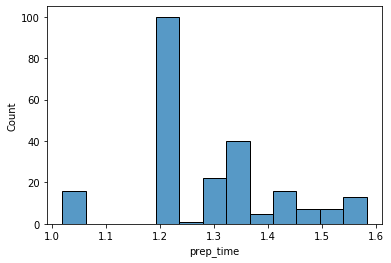

In [44]:
sns.histplot(data=data_improve, x='prep_time')

In [45]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(data_improve.drop('cook_time', axis=1), data_improve['cook_time'],
 test_size=0.15, random_state=0)

# 4. Feature selection

We will use 3 different feature selection methods to select the best subset of features. 

*"Logistic Regression is a good model for testing feature selection methods as it can perform better if irrelevant features are removed from the model"*

### 4.1 Mutual Information model - Logistic Regression

In [46]:
from functools import partial
discrete_feat_idx = range(1, 31)
score_func = partial(mutual_info_classif, discrete_features=discrete_feat_idx, random_state=0)
k_vals = [x for x in range(1, 32)]

In [47]:
def select_features_mutual_info(X_train, Y_train, X_test, k_val):
    fs = SelectKBest(score_func=score_func, k=k_val)
    fs.fit(X_train, Y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

x_train_fs, x_test_fs, fs = select_features_mutual_info(x_train2, y_train2, x_test2, 'all')

<BarContainer object of 31 artists>

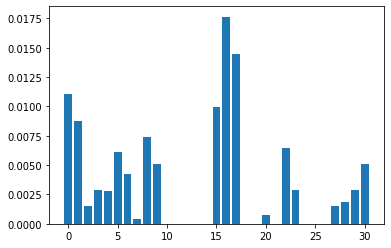

In [48]:
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

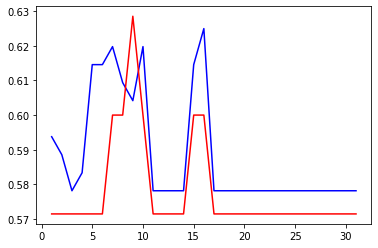

In [49]:
train_acc = []
test_acc = []
for k in k_vals:
    x_train_fs, x_test_fs, fs = select_features_mutual_info(x_train2, y_train2, x_test2, k_val=k)
    lr_mutual_info = LogisticRegressionCV(cv=5, n_jobs=-1)
    lr_mutual_info.fit(x_train_fs, y_train2)
    train_acc.append(lr_mutual_info.score(x_train_fs, y_train2))
    test_acc.append(lr_mutual_info.score(x_test_fs, y_test2))
plt.plot(k_vals, train_acc, color="blue")
plt.plot(k_vals, test_acc, color="red")
plt.show()

In [50]:
train_acc = []
test_acc = []

import warnings
# suppress warnings about convergence
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for k in k_vals:
        x_train_fs, x_test_fs, fs = select_features_mutual_info(x_train, y_train, x_test, k_val=k)
        lr_mutual_info = LogisticRegressionCV(cv=5, n_jobs=-1)
        lr_mutual_info.fit(x_train_fs, y_train)
        train_acc.append(lr_mutual_info.score(x_train_fs, y_train))
        test_acc.append(lr_mutual_info.score(x_test_fs, y_test))


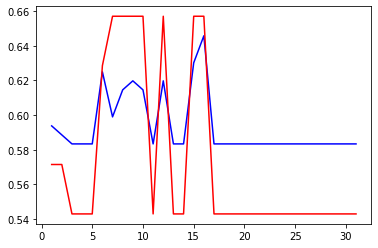

In [51]:
plt.plot(k_vals, train_acc, color="blue")
plt.plot(k_vals, test_acc, color="red")
plt.show()

Transforming the continuous variable - prep_time, help Logistic Regression converges faster, but ended up hurting the performance compared to the baseline model. The best logistic regression model obtained is with 7 features.

### 4.2 Chi-square - Logistic Regression

<BarContainer object of 31 artists>

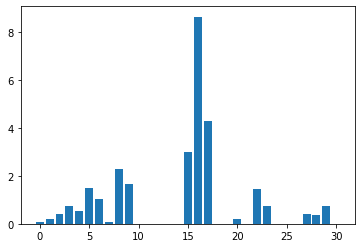

In [52]:
def select_features_chi2(X_train, Y_train, X_test, k_val):
    fs = SelectKBest(score_func=chi2, k=k_val)
    fs.fit(X_train, Y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

x_train_fs, x_test_fs, fs = select_features_chi2(x_train2, y_train2, x_test2, 'all')

plt.bar([i for i in range(len(fs.scores_))], fs.scores_)

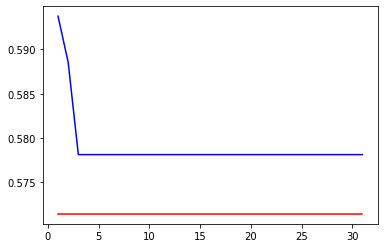

In [53]:
train_acc = []
test_acc = []
for k in k_vals:
    x_train_fs, x_test_fs, fs = select_features_chi2(x_train2, y_train2, x_test2, k_val=k)
    lr_mutual_info = LogisticRegressionCV(cv=4, n_jobs=-1)
    lr_mutual_info.fit(x_train_fs, y_train2)
    train_acc.append(lr_mutual_info.score(x_train_fs, y_train2))
    test_acc.append(lr_mutual_info.score(x_test_fs, y_test2))
plt.plot(k_vals, train_acc, color="blue")
plt.plot(k_vals, test_acc, color="red")
plt.show()

### 4.3 Mutual Information - Random Forest

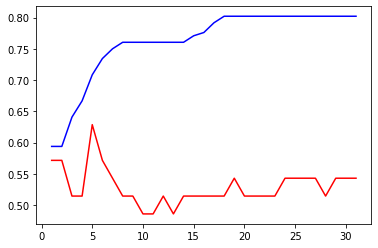

In [54]:
train_acc = []
test_acc = []
for k in k_vals:
    x_train_fs, x_test_fs, fs = select_features_mutual_info(x_train2, y_train2, x_test2, k_val=k)
    rfc = RandomForestClassifier(random_state=8)
    rfc.fit(x_train_fs, y_train2)
    train_acc.append(rfc.score(x_train_fs, y_train2))
    test_acc.append(rfc.score(x_test_fs, y_test2))
plt.plot(k_vals, train_acc, color="blue")
plt.plot(k_vals, test_acc, color="red")
plt.show()

### 4.4 Chi-square - Random Forest

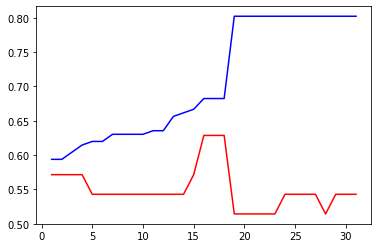

In [55]:
train_acc = []
test_acc = []
for k in k_vals:
    x_train_fs, x_test_fs, fs = select_features_chi2(x_train2, y_train2, x_test2, k_val=k)
    rfc = RandomForestClassifier(random_state=8)
    rfc.fit(x_train_fs, y_train2)
    train_acc.append(rfc.score(x_train_fs, y_train2))
    test_acc.append(rfc.score(x_test_fs, y_test2))
plt.plot(k_vals, train_acc, color="blue")
plt.plot(k_vals, test_acc, color="red")
plt.show()

Chi-square yields not as good results as mutual_information, maybe it's because chi-square doesn't take into account the fact that prep_time is a contiuous variable. The mutual information best subset selection technique improves the Random Forest model greatly (driving the test accuracy from 53 to 60%), but it's still not as good as logistic regression model. The best subset is a subset of 6 features

# 5. Model tuning

In [119]:
# finalized logistic model
x_train_fs, x_test_fs, fs = select_features_mutual_info(x_train2, y_train2, x_test2, k_val=9)

In [120]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
tune_lr = LogisticRegression(max_iter = 1000)

C = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]
solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
class_weight = ['balanced', None]

param_grid = {
    'C': C,
    'solver': solver,
    'class_weight': class_weight}
cv_sets = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 0)
grid_search = GridSearchCV(tune_lr, param_grid = param_grid, scoring='accuracy',cv=cv_sets,verbose=1, n_jobs=-1)

grid_search.fit(x_train_fs, y_train2)
print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

Fitting 3 folds for each of 80 candidates, totalling 240 fits
Best parameter (CV score=0.599):
{'logistic__C': 0.1, 'logistic__class_weight': None, 'logistic__solver': 'newton-cg'}


In [121]:
# finalized rf model
x_train_fs, x_test_fs, fs = select_features_mutual_info(x_train2, y_train2, x_test2, k_val=5)

In [129]:
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.model_selection import RandomizedSearchCV

rfcpipe = Pipeline([
    ('smote', SMOTENC(categorical_features = range(1, 5), k_neighbors = 4, random_state=0)),
    ('rfc', RandomForestClassifier(verbose = 3, n_jobs = -1))])

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {
    'rfc__n_estimators': n_estimators,
    'rfc__max_features': max_features,
    'rfc__max_depth': max_depth,
    'rfc__min_samples_split': min_samples_split,
    'rfc__min_samples_leaf': min_samples_leaf,
    'rfc__bootstrap': bootstrap}
cv_sets = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 0)
random_search_rfc = RandomizedSearchCV(
    rfcpipe, param_distributions = random_grid, scoring='accuracy',cv=3, n_jobs=-1, n_iter=50)

random_search_rfc.fit(x_train_fs, y_train2)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s


building tree 1 of 200building tree 2 of 200building tree 3 of 200


building tree 4 of 200
building tree 5 of 200
building tree 6 of 200building tree 7 of 200
building tree 8 of 200
building tree 9 of 200

building tree 10 of 200building tree 11 of 200

building tree 12 of 200
building tree 13 of 200
building tree 14 of 200building tree 15 of 200

building tree 16 of 200
building tree 17 of 200building tree 18 of 200

building tree 19 of 200
building tree 20 of 200
building tree 21 of 200building tree 22 of 200

building tree 23 of 200
building tree 24 of 200
building tree 25 of 200building tree 26 of 200

building tree 27 of 200
building tree 28 of 200building tree 29 of 200
building tree 30 of 200

building tree 31 of 200building tree 32 of 200building tree 33 of 200


building tree 34 of 200building tree 35 of 200
building tree 36 of 200
building tree 37 of 200building tree 38 of 200


building tree 39 of 200
building tree 40 of 200building tree 41 of 200building tree 42 of 200


b

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    0.5s


building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200building tree 147 of 200

building tree 148 of 200building tree 149 of 200

building tree 150 of 200
building tree 151 of 200building tree 152 of 200building tree 153 of 200

building tree 154 of 200

building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.8s finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('smote',
                                              SMOTENC(categorical_features=range(1, 5),
                                                      k_neighbors=4,
                                                      random_state=0)),
                                             ('rfc',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     verbose=3))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'rfc__bootstrap': [True, False],
                                        'rfc__max_depth': [20, 40, 60, 80, 100,
                                                           None],
                                        'rfc__max_features': ['auto', 'sqrt',
                                                              'log2'],
                                        'rfc__min_samples_leaf': 

In [131]:
print("Best parameter (CV score=%0.3f):" % random_search_rfc.best_score_)
print(random_search_rfc.best_params_)

Best parameter (CV score=0.542):
{'rfc__n_estimators': 200, 'rfc__min_samples_split': 2, 'rfc__min_samples_leaf': 1, 'rfc__max_features': 'sqrt', 'rfc__max_depth': None, 'rfc__bootstrap': True}


In [132]:
rfcpipe2 = Pipeline([
    ('rfc', RandomForestClassifier(verbose = 3, n_jobs = -1))])


n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
max_features = ['sqrt']
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {
    'rfc__n_estimators': n_estimators,
    'rfc__max_features': max_features,
    'rfc__max_depth': max_depth,
    'rfc__min_samples_split': min_samples_split,
    'rfc__min_samples_leaf': min_samples_leaf,
    'rfc__bootstrap': bootstrap}
cv_sets = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 0)
random_search_rfc2 = RandomizedSearchCV(
    rfcpipe2, param_distributions = random_grid, scoring='accuracy',cv=3, n_jobs=-1, n_iter=50)

random_search_rfc2.fit(x_train_fs, y_train2)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s


building tree 1 of 800building tree 2 of 800building tree 3 of 800


building tree 4 of 800
building tree 5 of 800
building tree 6 of 800
building tree 7 of 800
building tree 8 of 800building tree 9 of 800

building tree 10 of 800
building tree 11 of 800building tree 12 of 800

building tree 13 of 800
building tree 14 of 800
building tree 15 of 800building tree 16 of 800

building tree 17 of 800building tree 18 of 800

building tree 19 of 800
building tree 20 of 800
building tree 21 of 800building tree 22 of 800

building tree 23 of 800building tree 24 of 800

building tree 25 of 800building tree 26 of 800

building tree 27 of 800
building tree 28 of 800
building tree 29 of 800
building tree 30 of 800
building tree 31 of 800building tree 32 of 800

building tree 33 of 800
building tree 34 of 800building tree 35 of 800

building tree 36 of 800
building tree 37 of 800
building tree 38 of 800
building tree 39 of 800building tree 40 of 800

building tree 41 of 800
building tree 42 of 800
b

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    0.3s



building tree 199 of 800building tree 200 of 800
building tree 201 of 800
building tree 202 of 800
building tree 203 of 800
building tree 204 of 800building tree 205 of 800
building tree 206 of 800

building tree 207 of 800building tree 208 of 800
building tree 209 of 800
building tree 210 of 800
building tree 211 of 800
building tree 212 of 800
building tree 213 of 800
building tree 214 of 800
building tree 215 of 800

building tree 216 of 800
building tree 217 of 800
building tree 218 of 800
building tree 219 of 800
building tree 220 of 800
building tree 221 of 800

building tree 222 of 800
building tree 223 of 800
building tree 224 of 800
building tree 225 of 800
building tree 226 of 800
building tree 227 of 800
building tree 228 of 800
building tree 229 of 800
building tree 230 of 800
building tree 231 of 800
building tree 232 of 800
building tree 233 of 800
building tree 234 of 800
building tree 235 of 800
building tree 236 of 800
building tree 237 of 800
building tree 238 of 800

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    0.6s


building tree 313 of 800
building tree 314 of 800
building tree 315 of 800

building tree 316 of 800
building tree 317 of 800
building tree 318 of 800
building tree 319 of 800
building tree 320 of 800
building tree 321 of 800
building tree 322 of 800
building tree 323 of 800
building tree 324 of 800
building tree 325 of 800
building tree 326 of 800
building tree 327 of 800
building tree 328 of 800
building tree 329 of 800
building tree 330 of 800
building tree 331 of 800
building tree 332 of 800
building tree 333 of 800
building tree 334 of 800
building tree 335 of 800
building tree 336 of 800
building tree 337 of 800
building tree 338 of 800
building tree 339 of 800
building tree 340 of 800
building tree 341 of 800
building tree 342 of 800
building tree 343 of 800
building tree 344 of 800
building tree 345 of 800
building tree 346 of 800
building tree 347 of 800
building tree 348 of 800
building tree 349 of 800
building tree 350 of 800
building tree 351 of 800
building tree 352 of 800

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    1.0s


building tree 558 of 800
building tree 559 of 800
building tree 560 of 800
building tree 561 of 800
building tree 562 of 800
building tree 563 of 800
building tree 564 of 800
building tree 565 of 800
building tree 566 of 800
building tree 567 of 800
building tree 568 of 800
building tree 569 of 800
building tree 570 of 800
building tree 571 of 800
building tree 572 of 800
building tree 573 of 800
building tree 574 of 800
building tree 575 of 800
building tree 576 of 800
building tree 577 of 800
building tree 578 of 800

building tree 579 of 800
building tree 580 of 800
building tree 581 of 800
building tree 582 of 800
building tree 583 of 800
building tree 584 of 800
building tree 585 of 800
building tree 586 of 800
building tree 587 of 800
building tree 588 of 800
building tree 589 of 800
building tree 590 of 800
building tree 591 of 800
building tree 592 of 800
building tree 593 of 800
building tree 594 of 800
building tree 595 of 800
building tree 596 of 800
building tree 597 of 800

[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.5s finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('rfc',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     verbose=3))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'rfc__bootstrap': [True, False],
                                        'rfc__max_depth': [20, 40, 60, 80, 100,
                                                           None],
                                        'rfc__max_features': ['sqrt'],
                                        'rfc__min_samples_leaf': [1, 2, 4],
                                        'rfc__min_samples_split': [2, 5, 10],
                                        'rfc__n_estimators': [200, 400, 600,
                                                              800, 1000]},
                   scoring='accuracy')

In [133]:
print("Best parameter (CV score=%0.3f):" % random_search_rfc2.best_score_)
print(random_search_rfc2.best_params_)

Best parameter (CV score=0.568):
{'rfc__n_estimators': 800, 'rfc__min_samples_split': 2, 'rfc__min_samples_leaf': 1, 'rfc__max_features': 'sqrt', 'rfc__max_depth': 40, 'rfc__bootstrap': True}
